In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib        import rcParams, rc
from scipy.interpolate import splrep, BSpline

In [2]:
# Change the matplotlib default parameters for pretty plots
rcParams.update({'font.size':   14})
rcParams.update({'figure.dpi': 250})
rc('font', family='serif')
rc('text', usetex=True)

In [3]:
N = 25     # Number of data points
L = 1.0    # Size of the domain

λ  = 10.0   # Prior std
ση =  1.0   # std on η data
σχ =  2.5   # std on χ data

I0 = 1.0   # Boundary condition

# Define the locations of the data points
a = np.linspace(0, L, N, endpoint=True)

# Define the (true) emissivity (η) and opaciy (χ) functions
η = lambda x: 7.0*np.exp(-110.0*(x-2*L/5)**2) + 9.0*np.exp(-170.0*(x-3*L/5)**2) + 7.0*np.exp(-170.0*(x-4*L/5)**2)
χ = lambda x: 9.0*np.exp(-110.0*(x-2*L/5)**2) + 5.3*np.exp(-170.0*(x-3*L/5)**2) + 4.7*np.exp(-170.0*(x-4*L/5)**2)

In [4]:
# Define the BSpline basis functions
# (by interpolating basis vectors on the data)
def BSpline_basis(i, xs):
    ys    = np.zeros(len(xs))
    ys[i] = 1.0
    t, c, k = splrep(xs, ys, s=0, k=5)
    return BSpline(t, c, k)

In [5]:
# Define helper constants
cη = λ**2 / (λ**2 + ση**2)
cχ = λ**2 / (λ**2 + σχ**2)

# Define the set of basis functions
Φ = [BSpline_basis(i, a) for i in range(N)]

# Define the numerical domain (for integration)
xs = np.linspace(0, L, 1000)
# Extract the increment
dx = np.mean(np.diff(xs))

# Discretise the basis functions on the domain xs
Φm = np.array([Φ[i](xs) for i in range(N)])

# Compute the (discretised) emissivity interpolation functions and its variance
ηm_s0_s   = cη       * np.einsum('i , ij -> j', η(a), Φm) 
Em_s0_s_η = cη*ση**2 * np.einsum('ij, ij -> j', Φm  , Φm)

# Compute the 1σ confidence interval (CI) for the emissivity
ηm_s0_s_CI_min = ηm_s0_s - np.sqrt(Em_s0_s_η)
ηm_s0_s_CI_max = ηm_s0_s + np.sqrt(Em_s0_s_η)

# Compute the (discretised) opacity interpolation functions and its variance
χm_s0_s   = cχ       * np.einsum('i,  ij -> j', χ(a), Φm)
Em_s0_s_χ = cχ*σχ**2 * np.einsum('ij, ij -> j', Φm  , Φm)

# Compute the 1σ confidence interval (CI) for the opacity
χm_s0_s_CI_min = χm_s0_s - np.sqrt(Em_s0_s_χ)
χm_s0_s_CI_max = χm_s0_s + np.sqrt(Em_s0_s_χ)

# Numerically integrate the basis functions
# to get the discretised Ψ_τ functions
Ψm_τ = np.cumsum(dx*Φm, axis=1)

# Compute the (discretised) optical depth and its variance
τm_s0_s   = cχ       * np.einsum('i , ij -> j', χ(a), Ψm_τ) 
Em_s0_s_τ = cχ*σχ**2 * np.einsum('ij, ij -> j', Ψm_τ, Ψm_τ)

# Compute the (discretised) effective optical depth
τm_s0_s_eff_h = τm_s0_s - 0.5*Em_s0_s_τ
τm_s0_s_eff_b = τm_s0_s -     Em_s0_s_τ

# Compute the 1σ confidence interval (CI) for the optical depth
τm_s0_s_CI_min = τm_s0_s - np.sqrt(Em_s0_s_τ)
τm_s0_s_CI_max = τm_s0_s + np.sqrt(Em_s0_s_τ)

# Numerically integrate the basis functions
# to get the discretised Ψ_I functions
Ψm_I_h = np.exp(-τm_s0_s_eff_h) * np.cumsum(dx*Φm*np.exp(τm_s0_s_eff_h), axis=1)
Ψm_I_b = np.exp(-τm_s0_s_eff_b) * np.cumsum(dx*Φm*np.exp(τm_s0_s_eff_b), axis=1)

# Compute the (discretised) intensity and its variance
Im_s0_s_h = cη       * np.einsum('i , ij -> j', η(a),   Ψm_I_h) + I0*np.exp(-τm_s0_s_eff_h)
Im_s0_s_b = cη       * np.einsum('i , ij -> j', η(a),   Ψm_I_b) + I0*np.exp(-τm_s0_s_eff_b) 
Em_s0_s_I = cη*ση**2 * np.einsum('ij, ij -> j', Ψm_I_b, Ψm_I_b) + Im_s0_s_b**2 - Im_s0_s_h**2

# Compute the 1σ confidence interval (CI) for the intensity
Im_s0_s_CI_min = Im_s0_s_h - np.sqrt(Em_s0_s_I)
Im_s0_s_CI_max = Im_s0_s_h + np.sqrt(Em_s0_s_I)

In the computation of $\boldsymbol{\psi}_{I}(s)$, we used that,
\begin{align}
    \boldsymbol{\psi}_{I}(s)
    \ &\equiv \
    \int_{s_{0}}^{s} \text{d} s' \ \boldsymbol{\phi}(s') \, e^{-\hat{\tau}(s', \, s)} \\
    \ &= \
    e^{-\hat{\tau}(s_{0}, \, s)} \int_{s_{0}}^{s} \text{d} s' \ \boldsymbol{\phi}(s') \, e^{\hat{\tau}(s_{0}, \, s')} .
\end{align}

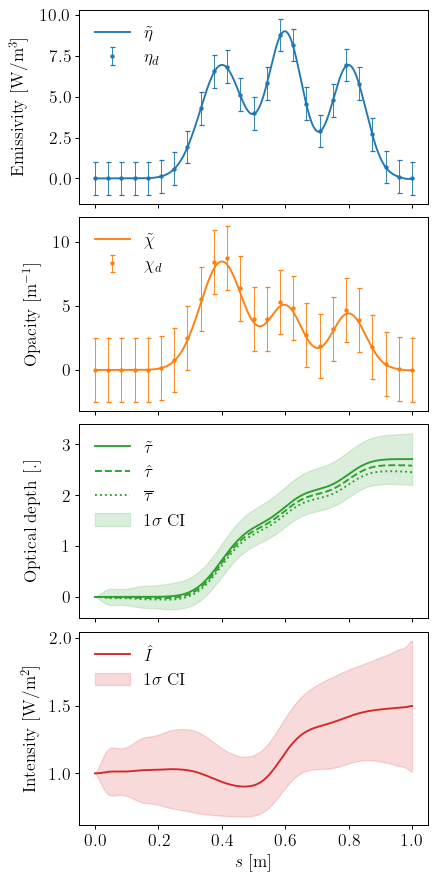

In [8]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
                                nrows=4, ncols=1, sharex=True, figsize=(5,12), dpi=90,
                                gridspec_kw={'hspace': 0.07}
                            )

ax0.errorbar    (a , η(a), ση, c='tab:blue', markersize=5, elinewidth=.7, linestyle='None', capsize=2, fmt='.', label=r'$\eta_{d}$')
ax0.plot        (xs, ηm_s0_s,                        color='tab:blue',   label=r'$\tilde{\eta}$')
# ax0.fill_between(xs, ηm_s0_s_CI_min, ηm_s0_s_CI_max, color='tab:blue',   alpha=0.17)
ax0.set_ylabel  ('Emissivity [W/m$^{3}$]', labelpad=10)
ax0.legend      (frameon=False, loc='upper left')

ax1.errorbar    (a , χ(a), σχ, c='tab:orange', markersize=5, elinewidth=.7, linestyle='None', capsize=2, fmt='.', label=r'$\chi_{d}$')
ax1.plot        (xs, χm_s0_s,                        color='tab:orange', label=r'$\tilde{\chi}$')
# ax1.fill_between(xs, χm_s0_s_CI_min, χm_s0_s_CI_max, color='tab:orange', alpha=0.17)
ax1.set_ylabel  ('Opacity [m$^{-1}$]', labelpad=10)
ax1.legend      (frameon=False, loc='upper left')

ax2.plot        (xs, τm_s0_s,                        color='tab:green',  label=r'$\tilde{\tau}$')
ax2.plot        (xs, τm_s0_s_eff_h, '--',            color='tab:green',  label=r'$\hat{\tau}$')
ax2.plot        (xs, τm_s0_s_eff_b, ':',             color='tab:green',  label=r'$\overline{\tau}$')
ax2.fill_between(xs, τm_s0_s_CI_min, τm_s0_s_CI_max, color='tab:green',  label=r'1$\sigma$ CI', alpha=0.17)
ax2.set_ylabel  ('Optical depth [.]', labelpad=17)
ax2.legend      (frameon=False, loc='upper left')

ax3.plot        (xs, Im_s0_s_h,                      color='tab:red',    label=r'$\hat{I}$')
ax3.fill_between(xs, Im_s0_s_CI_min, Im_s0_s_CI_max, color='tab:red',    label=r'1$\sigma$ CI', alpha=0.17)
ax3.set_xlabel  ('$s$ [m]')
ax3.set_ylabel  ('Intensity [W/m$^{2}$]', labelpad=7)
ax3.legend      (frameon=False, loc='upper left')

plt.savefig('example.pdf', bbox_inches='tight')